In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [4]:
import keras
import keras.backend as K
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15753296424844948732, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9214062756
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12119473020900622026
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [6]:
import os
import numpy as np
np.random.seed(777)

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop

from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, GlobalAveragePooling2D

from keras.regularizers import l2
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
output_classes = 2
batch_size = 8
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 50

nb_train_samples = 59168
nb_validation_samples = 18384
nb_test_samples = 967

In [12]:
train_dir = 'data/train/'
validation_dir = 'data/validation'
test_dir = 'data/test2'

In [ ]:
# if K.image_data_format() == 'channels_first':
#     input_shape = (3, img_width, img_height)
# else:
#     input_shape = (img_width, img_height, 3)

In [9]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/train/ 0
data/train/malignant 40424
data/train/normal 18744
******************************
data/validation 0
data/validation\malignant 12512
data/validation\normal 5872
******************************
data/test 0
data/test\malignant 10480
data/test\normal 4992


In [13]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 59168 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [11]:
from keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
prediction = Dense(output_classes, activation=tf.nn.softmax)(x)

model = Model(inputs=base_model.input,outputs=prediction)

In [17]:
# sgd_opt = SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)
# adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
sgd_opt = SGD(lr = 0.0001, momentum=0.7, decay=0.0, nesterov=False)
# rmsp_opt = RMSprop(lr=1e-4, decay=0.9)
# eve_opt = Eve(lr=1e-4, decay=1E-4, beta_1=0.9, beta_2=0.999, beta_3=0.999, small_k=0.1, big_K=10, epsilon=1e-08)

model.compile(optimizer= sgd_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [19]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size)

Epoch 1/50
7396/7396 [==============================] - 1244s 168ms/step - loss: 0.3229 - acc: 0.9450 - val_loss: 0.3378 - val_acc: 0.9382
Epoch 2/50
7396/7396 [==============================] - 1237s 167ms/step - loss: 0.2830 - acc: 0.9582 - val_loss: 0.3396 - val_acc: 0.9369
Epoch 3/50
7396/7396 [==============================] - 1235s 167ms/step - loss: 0.2696 - acc: 0.9640 - val_loss: 0.3383 - val_acc: 0.9364
Epoch 4/50
7396/7396 [==============================] - 1236s 167ms/step - loss: 0.2572 - acc: 0.9681 - val_loss: 0.3348 - val_acc: 0.9413
Epoch 5/50
7396/7396 [==============================] - 1232s 167ms/step - loss: 0.2431 - acc: 0.9722 - val_loss: 0.3376 - val_acc: 0.9382
Epoch 6/50
7396/7396 [==============================] - 1237s 167ms/step - loss: 0.2358 - acc: 0.9750 - val_loss: 0.3280 - val_acc: 0.9428
Epoch 7/50
7396/7396 [==============================] - 1235s 167ms/step - loss: 0.2257 - acc: 0.9787 - val_loss: 0.3324 - val_acc: 0.9423
Epoch 8/50
7396/7396 [=====

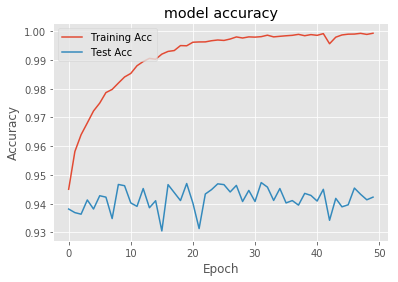

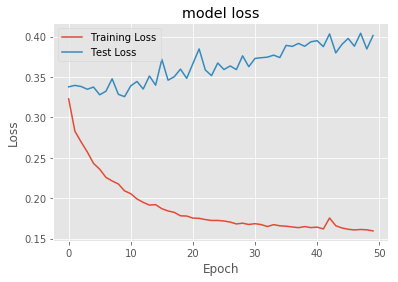

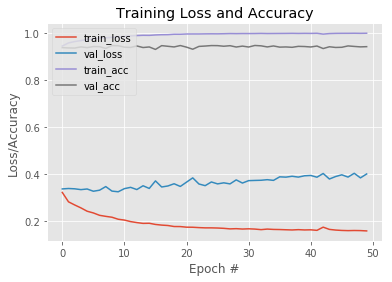

In [20]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [21]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.4850388178229332
Validation Accuracy:  0.9275


In [22]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

121/120 [==============================] - 7s 54ms/step
No of errors = 57/967


Confusion Matrix
[[636  19]
 [ 38 274]]


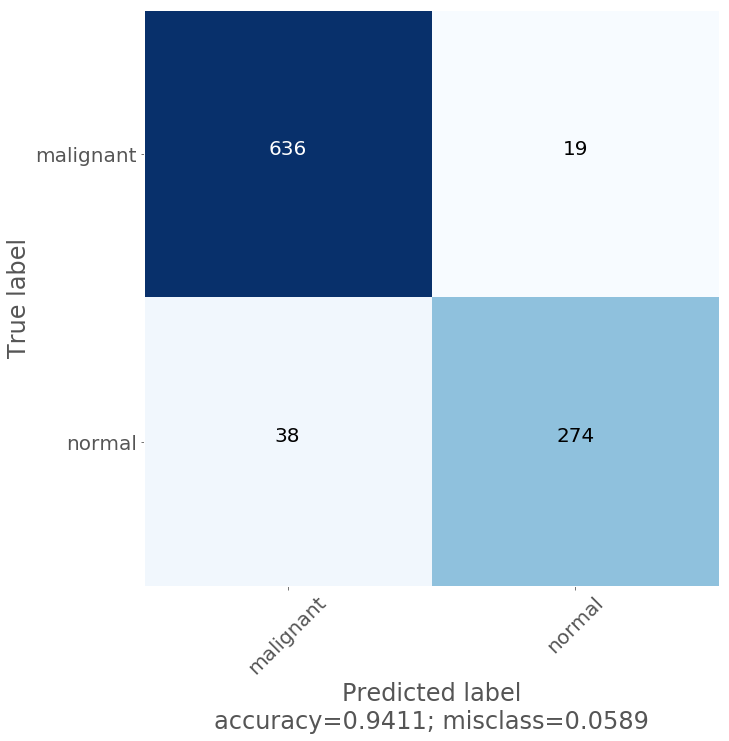

In [24]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[636  19]
 [ 38 274]]
              precision    recall  f1-score   support

   malignant       0.94      0.97      0.96       655
      normal       0.94      0.88      0.91       312

   micro avg       0.94      0.94      0.94       967
   macro avg       0.94      0.92      0.93       967
weighted avg       0.94      0.94      0.94       967



In [26]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Accuracy :  0.9410548086866598
Sensitivity :  0.9436201780415431
Specificity :  0.9351535836177475


In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.3f}'.format(acc))
print('Precision: {:.3f}'.format(prec))
print('Recall:    {:.3f}'.format(recall))
print('F1:        {:.3f}'.format(f1))

Accuracy:  0.941
Precision: 0.935
Recall:    0.878
F1:        0.906


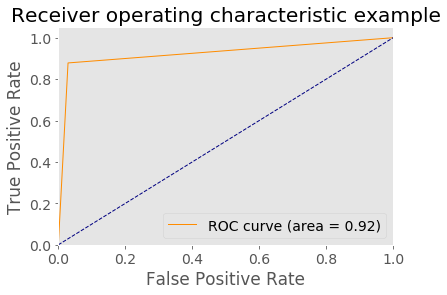

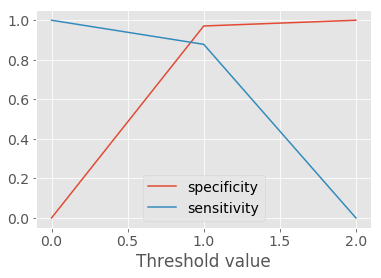

In [28]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()



In [29]:
model.save('models/16.DeneseNet121-ISBI19-SGD-Model.h5')
model.save_weights('models/16.DeneseNet121-ISBI19-SGD-Weights.h5')